In [42]:
! pip install -U -q torch torchvision torchaudio torchtext
! pip install -q sentencepiece
! pip install 'portalocker>=2.0.0'

In [43]:
import csv
import torch
import torchtext
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torchtext.datasets import IMDB
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torchtext.data.utils import ngrams_iterator
import sentencepiece as spm
import statistics as stats

import re
import string
import time
import copy
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

In [44]:
torchtext.__version__

'0.15.2+cpu'

In [45]:
torch.__version__

'2.0.1+cu118'

In [46]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
device

device(type='cpu')

In [47]:
train_iter = IMDB(split='train')

train_label_list = []
train_review_list = []

for label, line in train_iter:
  train_label_list.append(label)
  train_review_list.append(line)

train_keyword_list = [np.NaN for i in range(len(train_label_list))]
train_location_list = [np.NaN for i in range(len(train_label_list))]

train = pd.DataFrame({'keyword':train_keyword_list, 'location':train_location_list,
                   'text': train_review_list, 'target':train_label_list})

In [48]:
train.head()

,keyword,location,text,target
0,NaN,NaN,I rented I AM CURIOUS-YELLOW from my video sto...,1
1,NaN,NaN,"""I Am Curious: Yellow"" is a risible and preten...",1
2,NaN,NaN,If only to avoid making this type of film in t...,1
3,NaN,NaN,This film was probably inspired by Godard's Ma...,1
4,NaN,NaN,"Oh, brother...after hearing about this ridicul...",1


In [49]:
test_iter = IMDB(split='test')

test_label_list = []
test_review_list = []

for label, line in test_iter:
  test_label_list.append(label)
  test_review_list.append(line)

test_keyword_list = [np.NaN for i in range(len(test_label_list))]
test_location_list = [np.NaN for i in range(len(test_label_list))]

test = pd.DataFrame({'keyword':test_keyword_list, 'location':test_location_list,
                   'text': test_review_list, 'target':test_label_list})

In [50]:
test.head()

,keyword,location,text,target
0,NaN,NaN,I love sci-fi and am willing to put up with a ...,1
1,NaN,NaN,"Worth the entertainment value of a rental, esp...",1
2,NaN,NaN,its a totally average film with a few semi-alr...,1
3,NaN,NaN,STAR RATING: ***** Saturday Night **** Friday ...,1
4,NaN,NaN,"First off let me say, If you haven't enjoyed a...",1


In [51]:
train['target'].value_counts()

1    12500
2    12500
Name: target, dtype: int64

In [52]:
#Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [53]:
train['text_clean'] = train['text'].apply(clean_text)
train.head()

,keyword,location,text,target,text_clean
0,NaN,NaN,I rented I AM CURIOUS-YELLOW from my video sto...,1,i rented i am curiousyellow from my video stor...
1,NaN,NaN,"""I Am Curious: Yellow"" is a risible and preten...",1,i am curious yellow is a risible and pretentio...
2,NaN,NaN,If only to avoid making this type of film in t...,1,if only to avoid making this type of film in t...
3,NaN,NaN,This film was probably inspired by Godard's Ma...,1,this film was probably inspired by godards mas...
4,NaN,NaN,"Oh, brother...after hearing about this ridicul...",1,oh brotherafter hearing about this ridiculous ...


In [54]:
test['text_clean'] = test['text'].apply(clean_text)
test.head()

,keyword,location,text,target,text_clean
0,NaN,NaN,I love sci-fi and am willing to put up with a ...,1,i love scifi and am willing to put up with a l...
1,NaN,NaN,"Worth the entertainment value of a rental, esp...",1,worth the entertainment value of a rental espe...
2,NaN,NaN,its a totally average film with a few semi-alr...,1,its a totally average film with a few semialri...
3,NaN,NaN,STAR RATING: ***** Saturday Night **** Friday ...,1,star rating saturday night friday night fri...
4,NaN,NaN,"First off let me say, If you haven't enjoyed a...",1,first off let me say if you havent enjoyed a v...


In [55]:
!mkdir preprocessed_data
# save the cleaned texts as a plain file which is going to be the input for learning BPE tokenization
with open('preprocessed_data/train.text', 'w') as f:
  for text in train['text_clean']:
    f.write(f'{text.strip()}\n')

mkdir: cannot create directory ‘preprocessed_data’: File exists


In [56]:
VOCAB_SIZE = 8000

In [57]:
# learn a BPE tokenization model
spm.SentencePieceTrainer.train(input='preprocessed_data/train.text', model_prefix='bpe_model', vocab_size=VOCAB_SIZE, model_type='bpe')

In [58]:
sp = spm.SentencePieceProcessor(model_file='bpe_model.model')

def tokenize_into_str(text):
  return ' '.join(sp.encode(text, out_type=str))

def tokenize_into_idx(text):
  return ' '.join([str(tok) for tok in sp.encode(text)])

In [59]:
train['text_tokenized'] = train['text_clean'].apply(tokenize_into_str)
train['text_indices'] = train['text_clean'].apply(tokenize_into_idx)
train['text_indices'].replace('', np.nan, inplace=True)
train.dropna(subset=['text_indices'], inplace=True)
train.head()

,keyword,location,text,target,text_clean,text_tokenized,text_indices
0,NaN,NaN,I rented I AM CURIOUS-YELLOW from my video sto...,1,i rented i am curiousyellow from my video stor...,▁i ▁rented ▁i ▁am ▁curious ye llow ▁from ▁my ▁...,6 3518 6 260 4297 4458 789 177 222 1251 2756 3...
1,NaN,NaN,"""I Am Curious: Yellow"" is a risible and preten...",1,i am curious yellow is a risible and pretentio...,▁i ▁am ▁curious ▁yellow ▁is ▁a ▁ris ible ▁and ...,6 260 4297 7446 42 4 3926 661 30 4104 720 4879...
2,NaN,NaN,If only to avoid making this type of film in t...,1,if only to avoid making this type of film in t...,▁if ▁only ▁to ▁avoid ▁making ▁this ▁type ▁of ▁...,214 266 32 2031 853 62 1671 33 89 40 7 1928 62...
3,NaN,NaN,This film was probably inspired by Godard's Ma...,1,this film was probably inspired by godards mas...,▁this ▁film ▁was ▁probably ▁inspired ▁by ▁god ...,62 89 78 815 3746 163 1271 1459 14 2034 128 11...
4,NaN,NaN,"Oh, brother...after hearing about this ridicul...",1,oh brotherafter hearing about this ridiculous ...,▁oh ▁brother after ▁hearing ▁about ▁this ▁ridi...,1388 1693 4148 4685 198 62 1663 89 85 6916 219...


In [60]:
test['text_tokenized'] = test['text_clean'].apply(tokenize_into_str)
test['text_indices'] = test['text_clean'].apply(tokenize_into_idx)
test['text_indices'].replace('', np.nan, inplace=True)
test.dropna(subset=['text_indices'], inplace=True)
test.head()

,keyword,location,text,target,text_clean,text_tokenized,text_indices
0,NaN,NaN,I love sci-fi and am willing to put up with a ...,1,i love scifi and am willing to put up with a l...,▁i ▁love ▁scifi ▁and ▁am ▁willing ▁to ▁put ▁up...,6 418 2507 30 260 3706 32 758 240 94 4 536 250...
1,NaN,NaN,"Worth the entertainment value of a rental, esp...",1,worth the entertainment value of a rental espe...,▁worth ▁the ▁entertainment ▁value ▁of ▁a ▁rent...,783 7 1956 2720 33 4 4923 894 214 95 172 723 3...
2,NaN,NaN,its a totally average film with a few semi-alr...,1,its a totally average film with a few semialri...,▁its ▁a ▁totally ▁average ▁film ▁with ▁a ▁few ...,151 4 1452 2226 89 94 4 608 3739 599 1350 723 ...
3,NaN,NaN,STAR RATING: ***** Saturday Night **** Friday ...,1,star rating saturday night friday night fri...,▁star ▁rating ▁saturday ▁night ▁friday ▁night ...,787 1707 4819 813 5125 813 5125 4236 5471 813 ...
4,NaN,NaN,"First off let me say, If you haven't enjoyed a...",1,first off let me say if you havent enjoyed a v...,▁first ▁off ▁let ▁me ▁say ▁if ▁you ▁havent ▁en...,352 374 767 190 445 214 95 2020 1467 4 2043 17...


In [61]:
def count_tokens(text_indices):
  tokens = text_indices.split(' ')
  return len(tokens)

In [62]:
train['sequence_length'] = train['text_indices'].apply(count_tokens)
test['sequence_length'] = test['text_indices'].apply(count_tokens)

In [63]:
print(f"Train:\tmean={stats.mean(train['sequence_length']):.2f}\tstd={stats.stdev(train['sequence_length']):.2f}")
print(f"Test:\tmean={stats.mean(test['sequence_length']):.2f}\tstd={stats.stdev(test['sequence_length']):.2f}")

Train:	mean=268.81	std=207.25
Test:	mean=263.51	std=202.07


In [64]:
# split into training, validation and test data and save these in the preprocessed folder for loading
X = train[[col for col in train.columns if not col == 'target']]
y = train['target']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

train_data = pd.concat([X_train, y_train], axis=1)
valid_data = pd.concat([X_valid, y_valid], axis=1)

# save them
train_data.to_pickle('preprocessed_data/train.pkl')
valid_data.to_pickle('preprocessed_data/valid.pkl')

In [65]:
train_data.head(3)

,keyword,location,text,text_clean,text_tokenized,text_indices,sequence_length,target
6920,NaN,NaN,What made me track this movie down was the vie...,what made me track this movie down was the vie...,▁what ▁made ▁me ▁track ▁this ▁movie ▁down ▁was...,217 369 190 2879 62 100 604 78 7 2154 2144 799...,140,1
17926,NaN,NaN,"In ten words or less to describe this film, Ba...",in ten words or less to describe this film bar...,▁in ▁ten ▁words ▁or ▁less ▁to ▁describe ▁this ...,40 1740 1980 178 911 32 3650 62 89 4635 6622 4...,69,2
1123,NaN,NaN,*****THIS REVIEW MAY HAVE SPOILERS - but that ...,this review may have spoilers but that determ...,▁this ▁review ▁may ▁have ▁spoilers ▁but ▁that ...,62 990 472 130 2906 105 64 4357 1540 245 53 25...,401,1


In [66]:
train_data.iloc[3]['text_indices']

'6 646 878 64 7 1574 33 6467 7985 58 42 134 652 240 85 1897 64 162 245 2493 1605 163 7134 62 271 32 53 772 224 62 271 42 172 4 3795 40 7 1315 32 373 652 2160 1906 21 366 98 303 7752 6 130 429 606 40 222 458 421 785 134 1092 40 222 458 214 162 268 1922 35 46 82 4 738 64 245 53 144 377 105 32 445 46 42 1855 42 601 959 33 4 4781 6 266 712 46 979 30 78 657 3980 120 217 6 712 6 1447 32 238 7 441 794 234 359 4 1549 70 514 94 4 302 794 217 4 2473 64 245 130 342 601 63 7 271 78 256 1378 32 7 373 638 7 1574 33 6467 7985 58 7 1679 4692 30 145 7 7752 481 53 5027 277 4095 40 2204 30 481 429 431 12 2388 162 743 177 64 1574 220 679 46 584 1682 689 63 811'

In [67]:
class DisasterTweetsDataset(Dataset):
  def __init__(self, pickle_path):
    self.dataset = pd.read_pickle(pickle_path)

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    text_indices_string = self.dataset['text_indices'].iloc[idx]
    text_indices = [int(tok_idx) for tok_idx in text_indices_string.split(' ')]
    sequence_length = int(self.dataset['sequence_length'].iloc[idx])
    label = None
    if 'target' in self.dataset.columns:
      label = int(self.dataset['target'].iloc[idx])
    return text_indices, sequence_length, label

In [68]:
train_dataset = DisasterTweetsDataset('preprocessed_data/train.pkl')
valid_dataset = DisasterTweetsDataset('preprocessed_data/valid.pkl')

In [69]:
train_dataset[1]

([40,
  1740,
  1980,
  178,
  911,
  32,
  3650,
  62,
  89,
  4635,
  6622,
  42,
  361,
  4687,
  30,
  46,
  42,
  304,
  7,
  89,
  42,
  1226,
  1160,
  85,
  7,
  1306,
  4484,
  35,
  27,
  941,
  105,
  6,
  418,
  1858,
  306,
  677,
  1804,
  4635,
  6622,
  722,
  82,
  7,
  6407,
  11,
  874,
  7983,
  1194,
  7974,
  1843,
  7984,
  244,
  1171,
  42,
  1439,
  250,
  1954,
  217,
  250,
  1484,
  30,
  922,
  385,
  46,
  62,
  89,
  42,
  3017,
  30,
  1009],
 69,
 2)

In [72]:
label_pipeline = lambda x: int(x) - 1

def generate_batch(batch):
  batch_indices = []
  batch_labels = []
  offsets = [0]

  for text_indices, sequence_length, label in batch:
    batch_indices.extend(text_indices)
    batch_labels.append(label_pipeline(label))
    offsets.append(sequence_length)

  batch_indices = torch.tensor(batch_indices, dtype=torch.long)
  batch_labels = torch.tensor(batch_labels, dtype=torch.long)
  offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
  return batch_indices, offsets, batch_labels

In [73]:
BATCH_SIZE = 8
EMBED_DIM = 32
NUM_CLASS = 2

In [74]:
SEED = 42
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [75]:
class MLP(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)

        self.fc = nn.Linear(embed_dim, num_class)

        # initialize the weights
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)

        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()


    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [76]:
model = MLP(VOCAB_SIZE, EMBED_DIM, NUM_CLASS).to(device)

In [77]:
def train_func(train_loader):
    # Train the model
    train_loss = 0
    train_acc = 0
    total_size = 0
    for i, (text, offsets, cls) in enumerate(train_loader):

        total_size += len(cls)
        optimizer.zero_grad() #clear the gradients
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        #forward pass
        output = model(text, offsets)
        #get the loss
        loss = criterion(output, cls)
        train_loss += loss.item()
        #calculate gradients
        loss.backward()
        #update weights
        optimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()
    # Adjust the learning rate
    scheduler.step()
    return train_loss / total_size, train_acc / total_size

def valid_func(valid_loader):
    loss = 0
    acc = 0
    total_size = 0
    for text, offsets, cls in valid_loader:
        total_size += len(cls)
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = model(text, offsets)
            loss = criterion(output, cls)
            loss += loss.item()
            acc += (output.argmax(1) == cls).sum().item()
    return loss / total_size, acc / total_size

In [78]:
N_EPOCHS = 20
t = time.time()
loss=[]
acc=[]
val_acc=[]

min_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=generate_batch)

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train_func(train_loader)
    valid_loss, valid_acc = valid_func(valid_loader)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Acc: {valid_acc*100:.2f}%')

    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)

print(f'time:{time.time()-t:.3f}')

	Train Loss: 0.070 | Train Acc: 69.46%
	 Val. Acc: 72.13%
	Train Loss: 0.049 | Train Acc: 82.37%
	 Val. Acc: 73.20%
	Train Loss: 0.042 | Train Acc: 85.83%
	 Val. Acc: 71.89%
	Train Loss: 0.037 | Train Acc: 87.77%
	 Val. Acc: 86.93%
	Train Loss: 0.034 | Train Acc: 88.99%
	 Val. Acc: 87.28%
	Train Loss: 0.031 | Train Acc: 90.04%
	 Val. Acc: 87.41%
	Train Loss: 0.029 | Train Acc: 90.53%
	 Val. Acc: 87.33%
	Train Loss: 0.028 | Train Acc: 91.14%
	 Val. Acc: 85.18%
	Train Loss: 0.027 | Train Acc: 91.46%
	 Val. Acc: 85.39%
	Train Loss: 0.025 | Train Acc: 92.22%
	 Val. Acc: 87.71%
	Train Loss: 0.024 | Train Acc: 92.59%
	 Val. Acc: 87.57%
	Train Loss: 0.023 | Train Acc: 92.84%
	 Val. Acc: 87.74%
	Train Loss: 0.022 | Train Acc: 93.29%
	 Val. Acc: 86.83%
	Train Loss: 0.021 | Train Acc: 93.57%
	 Val. Acc: 87.55%
	Train Loss: 0.021 | Train Acc: 93.80%
	 Val. Acc: 87.47%
	Train Loss: 0.020 | Train Acc: 93.98%
	 Val. Acc: 87.30%
	Train Loss: 0.020 | Train Acc: 94.35%
	 Val. Acc: 87.62%
	Train Loss: 0

<function matplotlib.pyplot.show(close=None, block=None)>

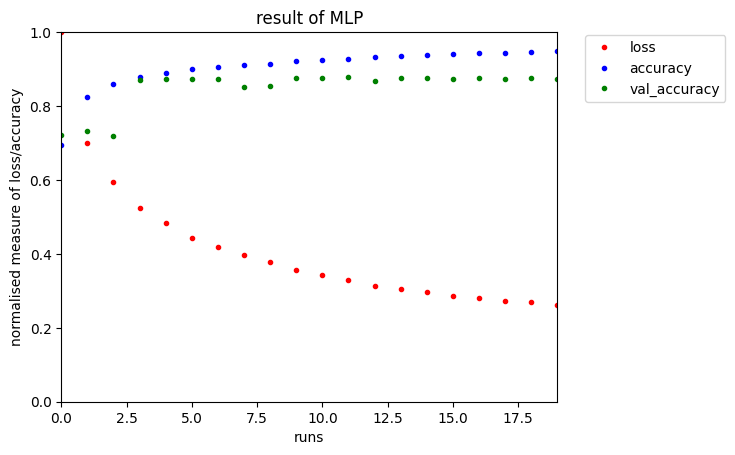

In [79]:
plt.xlabel("runs")
plt.ylabel("normalised measure of loss/accuracy")
x_len=list(range(len(acc)))
plt.axis([0, max(x_len), 0, 1])
plt.title('result of MLP')
loss=np.asarray(loss)/max(loss)
plt.plot(x_len, loss, 'r.',label="loss")
plt.plot(x_len, acc, 'b.', label="accuracy")
plt.plot(x_len, val_acc, 'g.', label="val_accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show

In [80]:
class MLP(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)

        num_layer = 100

        self.fc1 = nn.Linear(embed_dim , num_layer)
        self.fc2 = nn.Linear(num_layer , num_class)

        # initialize the weights
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)

        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()

        self.fc2.weight.data.uniform_(-initrange, initrange)
        self.fc2.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc2(self.fc1(embedded))

In [81]:
N_EPOCHS = 20
t = time.time()
loss=[]
acc=[]
val_acc=[]

min_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=generate_batch)

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train_func(train_loader)
    valid_loss, valid_acc = valid_func(valid_loader)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Acc: {valid_acc*100:.2f}%')

    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)

print(f'time:{time.time()-t:.3f}')

	Train Loss: 0.035 | Train Acc: 88.93%
	 Val. Acc: 86.85%
	Train Loss: 0.028 | Train Acc: 90.87%
	 Val. Acc: 79.60%
	Train Loss: 0.024 | Train Acc: 92.11%
	 Val. Acc: 87.63%
	Train Loss: 0.022 | Train Acc: 92.89%
	 Val. Acc: 86.80%
	Train Loss: 0.020 | Train Acc: 93.65%
	 Val. Acc: 86.27%
	Train Loss: 0.019 | Train Acc: 93.99%
	 Val. Acc: 87.01%
	Train Loss: 0.018 | Train Acc: 94.37%
	 Val. Acc: 87.20%
	Train Loss: 0.017 | Train Acc: 94.76%
	 Val. Acc: 87.36%
	Train Loss: 0.017 | Train Acc: 95.02%
	 Val. Acc: 87.41%
	Train Loss: 0.015 | Train Acc: 95.64%
	 Val. Acc: 87.22%
	Train Loss: 0.015 | Train Acc: 95.73%
	 Val. Acc: 86.56%
	Train Loss: 0.014 | Train Acc: 96.08%
	 Val. Acc: 83.78%
	Train Loss: 0.014 | Train Acc: 96.14%
	 Val. Acc: 87.18%
	Train Loss: 0.013 | Train Acc: 96.31%
	 Val. Acc: 86.82%
	Train Loss: 0.013 | Train Acc: 96.52%
	 Val. Acc: 87.14%
	Train Loss: 0.012 | Train Acc: 96.72%
	 Val. Acc: 87.10%
	Train Loss: 0.012 | Train Acc: 96.85%
	 Val. Acc: 86.72%
	Train Loss: 0

<function matplotlib.pyplot.show(close=None, block=None)>

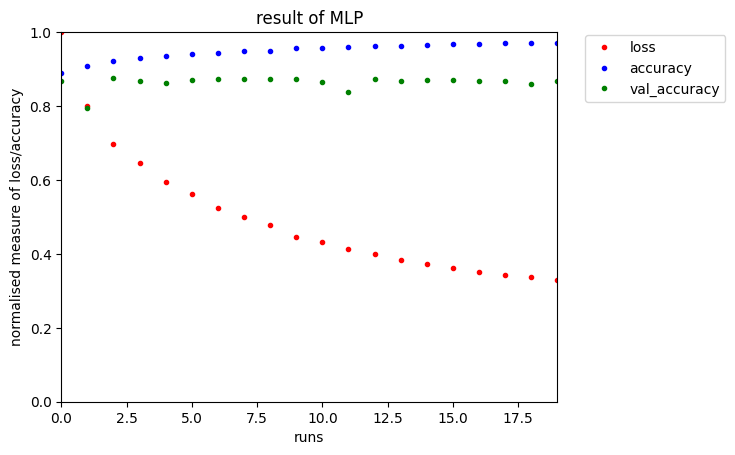

In [82]:
plt.xlabel("runs")
plt.ylabel("normalised measure of loss/accuracy")
x_len=list(range(len(acc)))
plt.axis([0, max(x_len), 0, 1])
plt.title('result of MLP')
loss=np.asarray(loss)/max(loss)
plt.plot(x_len, loss, 'r.',label="loss")
plt.plot(x_len, acc, 'b.', label="accuracy")
plt.plot(x_len, val_acc, 'g.', label="val_accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show

In [83]:
class MLP(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)

        num_layer = 200

        self.fc1 = nn.Linear(embed_dim , num_layer)
        self.fc2 = nn.Linear(num_layer , num_class)

        # initialize the weights
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)

        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()

        self.fc2.weight.data.uniform_(-initrange, initrange)
        self.fc2.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc2(self.fc1(embedded))

In [84]:
N_EPOCHS = 20
t = time.time()
loss=[]
acc=[]
val_acc=[]

min_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=generate_batch)

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train_func(train_loader)
    valid_loss, valid_acc = valid_func(valid_loader)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Acc: {valid_acc*100:.2f}%')

    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)

print(f'time:{time.time()-t:.3f}')

	Train Loss: 0.030 | Train Acc: 90.78%
	 Val. Acc: 83.66%
	Train Loss: 0.022 | Train Acc: 93.07%
	 Val. Acc: 86.83%
	Train Loss: 0.019 | Train Acc: 93.97%
	 Val. Acc: 86.72%
	Train Loss: 0.017 | Train Acc: 94.85%
	 Val. Acc: 86.50%
	Train Loss: 0.015 | Train Acc: 95.38%
	 Val. Acc: 87.01%
	Train Loss: 0.014 | Train Acc: 95.82%
	 Val. Acc: 86.00%
	Train Loss: 0.013 | Train Acc: 96.20%
	 Val. Acc: 86.86%
	Train Loss: 0.012 | Train Acc: 96.41%
	 Val. Acc: 86.21%
	Train Loss: 0.011 | Train Acc: 96.85%
	 Val. Acc: 86.64%
	Train Loss: 0.011 | Train Acc: 97.11%
	 Val. Acc: 86.62%
	Train Loss: 0.010 | Train Acc: 97.45%
	 Val. Acc: 86.70%
	Train Loss: 0.010 | Train Acc: 97.51%
	 Val. Acc: 86.14%
	Train Loss: 0.009 | Train Acc: 97.64%
	 Val. Acc: 86.53%
	Train Loss: 0.009 | Train Acc: 97.94%
	 Val. Acc: 86.56%
	Train Loss: 0.009 | Train Acc: 98.00%
	 Val. Acc: 86.66%
	Train Loss: 0.008 | Train Acc: 98.06%
	 Val. Acc: 86.29%
	Train Loss: 0.008 | Train Acc: 98.21%
	 Val. Acc: 86.40%
	Train Loss: 0

<function matplotlib.pyplot.show(close=None, block=None)>

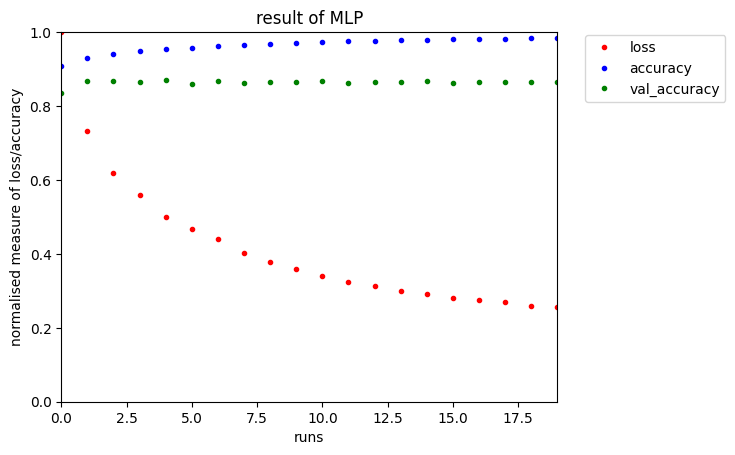

In [85]:
plt.xlabel("runs")
plt.ylabel("normalised measure of loss/accuracy")
x_len=list(range(len(acc)))
plt.axis([0, max(x_len), 0, 1])
plt.title('result of MLP')
loss=np.asarray(loss)/max(loss)
plt.plot(x_len, loss, 'r.',label="loss")
plt.plot(x_len, acc, 'b.', label="accuracy")
plt.plot(x_len, val_acc, 'g.', label="val_accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show